In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature, filters, transform
from scipy import ndimage
import cv2

# Set up path and envs

In [27]:
IMAGE_PATH = 'contrail_test_figure/contrail_showcase_2.png'

# Define the function

In [28]:
def load_and_preprocess(image_path):
    """Load and preprocess the image to enhance linear features."""
    # Load image
    img = io.imread(image_path)
    
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        # Handle 4-channel RGBA images
        if img.shape[2] == 4:
            # Convert RGBA to RGB by discarding alpha channel
            img_rgb = img[:, :, :3]
            gray = color.rgb2gray(img_rgb)
        elif img.shape[2] == 3:
            gray = color.rgb2gray(img)
        else:
            # Handle other multichannel cases
            gray = img[:, :, 0]  # Just use first channel
    else:
        gray = img

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_uint8 = (gray * 255).astype(np.uint8)
    enhanced = clahe.apply(gray_uint8)
    
    # Apply Gaussian blur to reduce noise
    blurred = filters.gaussian(enhanced, sigma=1.0, preserve_range=True).astype(np.uint8)
    
    return img, blurred

def create_line_kernel(size, angle_deg):
    """Create a line kernel for a specific angle in degrees."""
    kernel = np.zeros((size, size))
    center = size // 2
    
    # Convert angle from degrees to radians
    angle_rad = np.radians(angle_deg)
    
    # Create a line mask at the specified angle
    for i in range(-center, center + 1):
        # Calculate coordinates using parametric line equation
        x = int(center + i * np.cos(angle_rad))
        y = int(center + i * np.sin(angle_rad))
        
        # Check if coordinates are within bounds
        if 0 <= x < size and 0 <= y < size:
            kernel[y, x] = 1
    
    # Normalize kernel: subtract mean to get a zero-sum filter
    kernel = kernel - np.mean(kernel)
    
    # Further normalize so that the sum of squares is 1
    norm = np.sqrt(np.sum(kernel**2))
    if norm > 0:
        kernel = kernel / norm
        
    return kernel

def multi_angle_convolution_detection(img_gray, angles=None, kernel_size=21):
    """Detect linear features using multiple directional line kernels."""
    if angles is None:
        # Default angles: 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165 degrees
        angles = np.arange(0, 180, 15)
    
    # Create a kernel for each angle
    kernels = [create_line_kernel(kernel_size, angle) for angle in angles]
    
    # Apply convolution for each kernel
    responses = []
    for i, kernel in enumerate(kernels):
        response = ndimage.convolve(img_gray.astype(float), kernel)
        responses.append(response)
    
    # Store individual responses for visualization
    angle_responses = np.array(responses)
    
    # Combine responses by taking maximum at each pixel
    max_response = np.max(angle_responses, axis=0)
    
    # Get the index of the maximum response for each pixel
    max_angle_idx = np.argmax(angle_responses, axis=0)
    angle_map = np.array([angles[idx] for idx in max_angle_idx.flatten()]).reshape(max_angle_idx.shape)
    
    # Threshold response for binary detection
    threshold = np.percentile(max_response, 95)  # Top 5% of responses
    binary_detection = max_response > threshold
    
    return max_response, binary_detection, angle_responses, angle_map, max_angle_idx

def visualize_results(original_img, preprocessed, responses, binary_detection, angle_responses, angle_map, angles, max_angle_idx=None):
    """Visualize detection results with multiple angle responses."""
    # Create figure with subplots
    n_angles = len(angles)
    n_cols = 4  # Number of columns in the grid
    n_rows = int(np.ceil(n_angles / n_cols)) + 2  # +2 for original and combined result
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
    
    # Flatten axes for easier indexing if there's only one row
    if n_rows == 1:
        axes = np.array([axes])
    
    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Preprocessed image
    axes[0, 1].imshow(preprocessed, cmap='gray')
    axes[0, 1].set_title('Preprocessed Image')
    axes[0, 1].axis('off')
    
    # Combined response
    axes[0, 2].imshow(responses, cmap='hot')
    axes[0, 2].set_title('Combined Response')
    axes[0, 2].axis('off')
    
    # Binary detection
    axes[0, 3].imshow(binary_detection, cmap='gray')
    axes[0, 3].set_title('Binary Detection')
    axes[0, 3].axis('off')
    
    # Individual angle responses
    for i, angle in enumerate(angles):
        row = (i // n_cols) + 1
        col = i % n_cols
        
        # Handle case when we have more angles than subplot positions
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].imshow(angle_responses[i], cmap='hot')
            axes[row, col].set_title(f'Angle: {angle}°')
            axes[row, col].axis('off')
    
    # Color overlay on original image showing detected lines
    overlay_ax = axes[n_rows-1, 0]
    overlay_ax.imshow(original_img)
    
    # Create color mask based on binary detection
    mask = np.zeros((*original_img.shape[:2], 4))
    mask[binary_detection, 0] = 1.0  # Red channel
    mask[binary_detection, 3] = 0.5  # Alpha channel
    
    overlay_ax.imshow(mask)
    overlay_ax.set_title('Detected Lines Overlay')
    overlay_ax.axis('off')
    
    # Angle map visualization
    angle_vis_ax = axes[n_rows-1, 1]
    # Normalize angle map to 0-1 range for colormap
    norm_angle_map = angle_map / 180.0
    # Only show angles where binary detection is true
    colored_angles = np.zeros((*norm_angle_map.shape, 4))
    colored_angles[..., :3] = plt.cm.hsv(norm_angle_map)[..., :3]  # HSV colormap for angles
    colored_angles[..., 3] = binary_detection * 0.7  # Alpha channel based on detection
    
    angle_vis_ax.imshow(original_img)
    angle_vis_ax.imshow(colored_angles)
    angle_vis_ax.set_title('Angle Direction Map')
    angle_vis_ax.axis('off')
    
    # Add kernels visualization
    kernel_ax = axes[n_rows-1, 2]
    # Display all kernels side by side
    kernels_display = np.hstack([create_line_kernel(15, angle) for angle in angles[:4]])
    kernel_ax.imshow(kernels_display, cmap='gray')
    kernel_ax.set_title('Sample Kernels (0°, 15°, 30°, 45°)')
    kernel_ax.axis('off')
    
    # Hide any empty subplots
    for i in range(n_rows):
        for j in range(n_cols):
            if i >= 1 and i < n_rows-1 and (i-1)*n_cols + j >= n_angles:
                axes[i, j].axis('off')
                axes[i, j].set_visible(False)
            if i == n_rows-1 and j >= 3:
                axes[i, j].axis('off')
                axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('contrail_detection_directional.png', dpi=300)
    plt.show()
    
    # Create a separate figure for overlay visualization (larger and more detailed)
    plt.figure(figsize=(12, 10))
    plt.imshow(original_img)
    
    # Create a more detailed angle-based overlay
    detailed_overlay = np.zeros((*original_img.shape[:2], 4))
    
    # Create handles for the legend
    legend_handles = []
    
    # Color code by angle direction using HSV colormap (hue represents angle)
    for i, angle in enumerate(angles):
        # Create mask for this specific angle (where this angle had the max response)
        angle_mask = (max_angle_idx == i) & binary_detection
        
        # Set color based on angle (using HSV colormap)
        hue = angle / 180.0  # Normalize to 0-1 range
        rgb = plt.cm.hsv(hue)[:3]  # Get RGB from HSV colormap
        
        # Apply the color to the overlay
        detailed_overlay[angle_mask, 0] = rgb[0]  # R
        detailed_overlay[angle_mask, 1] = rgb[1]  # G
        detailed_overlay[angle_mask, 2] = rgb[2]  # B
        detailed_overlay[angle_mask, 3] = 0.7     # Alpha
        
        # Add to legend (only if there are pixels detected at this angle)
        if np.any(angle_mask):
            patch = plt.Line2D([0], [0], color=rgb, lw=4, label=f'{angle}°')
            legend_handles.append(patch)
    
    plt.imshow(detailed_overlay)
    plt.title('Contrail Detection: Color-coded by Direction', fontsize=14)
    
    # Add legend with angle labels
    if legend_handles:
        plt.legend(handles=legend_handles, loc='upper right', 
                  title='Line Direction', bbox_to_anchor=(1.2, 1), 
                  frameon=True, facecolor='white', framealpha=0.8)
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('contrail_direction_overlay.png', dpi=300)
    plt.show()

# Main execution

In [31]:
"""Main execution function."""
# Load and preprocess image
original_img, preprocessed = load_and_preprocess(IMAGE_PATH)

# Define angles for convolution kernels (0° to 175° in 30˚ steps)
angles = np.arange(0, 180, 15)

# Apply multi-angle convolution detection
max_response, binary_detection, angle_responses, angle_map, max_angle_idx = multi_angle_convolution_detection(
    preprocessed, angles=angles, kernel_size=21)

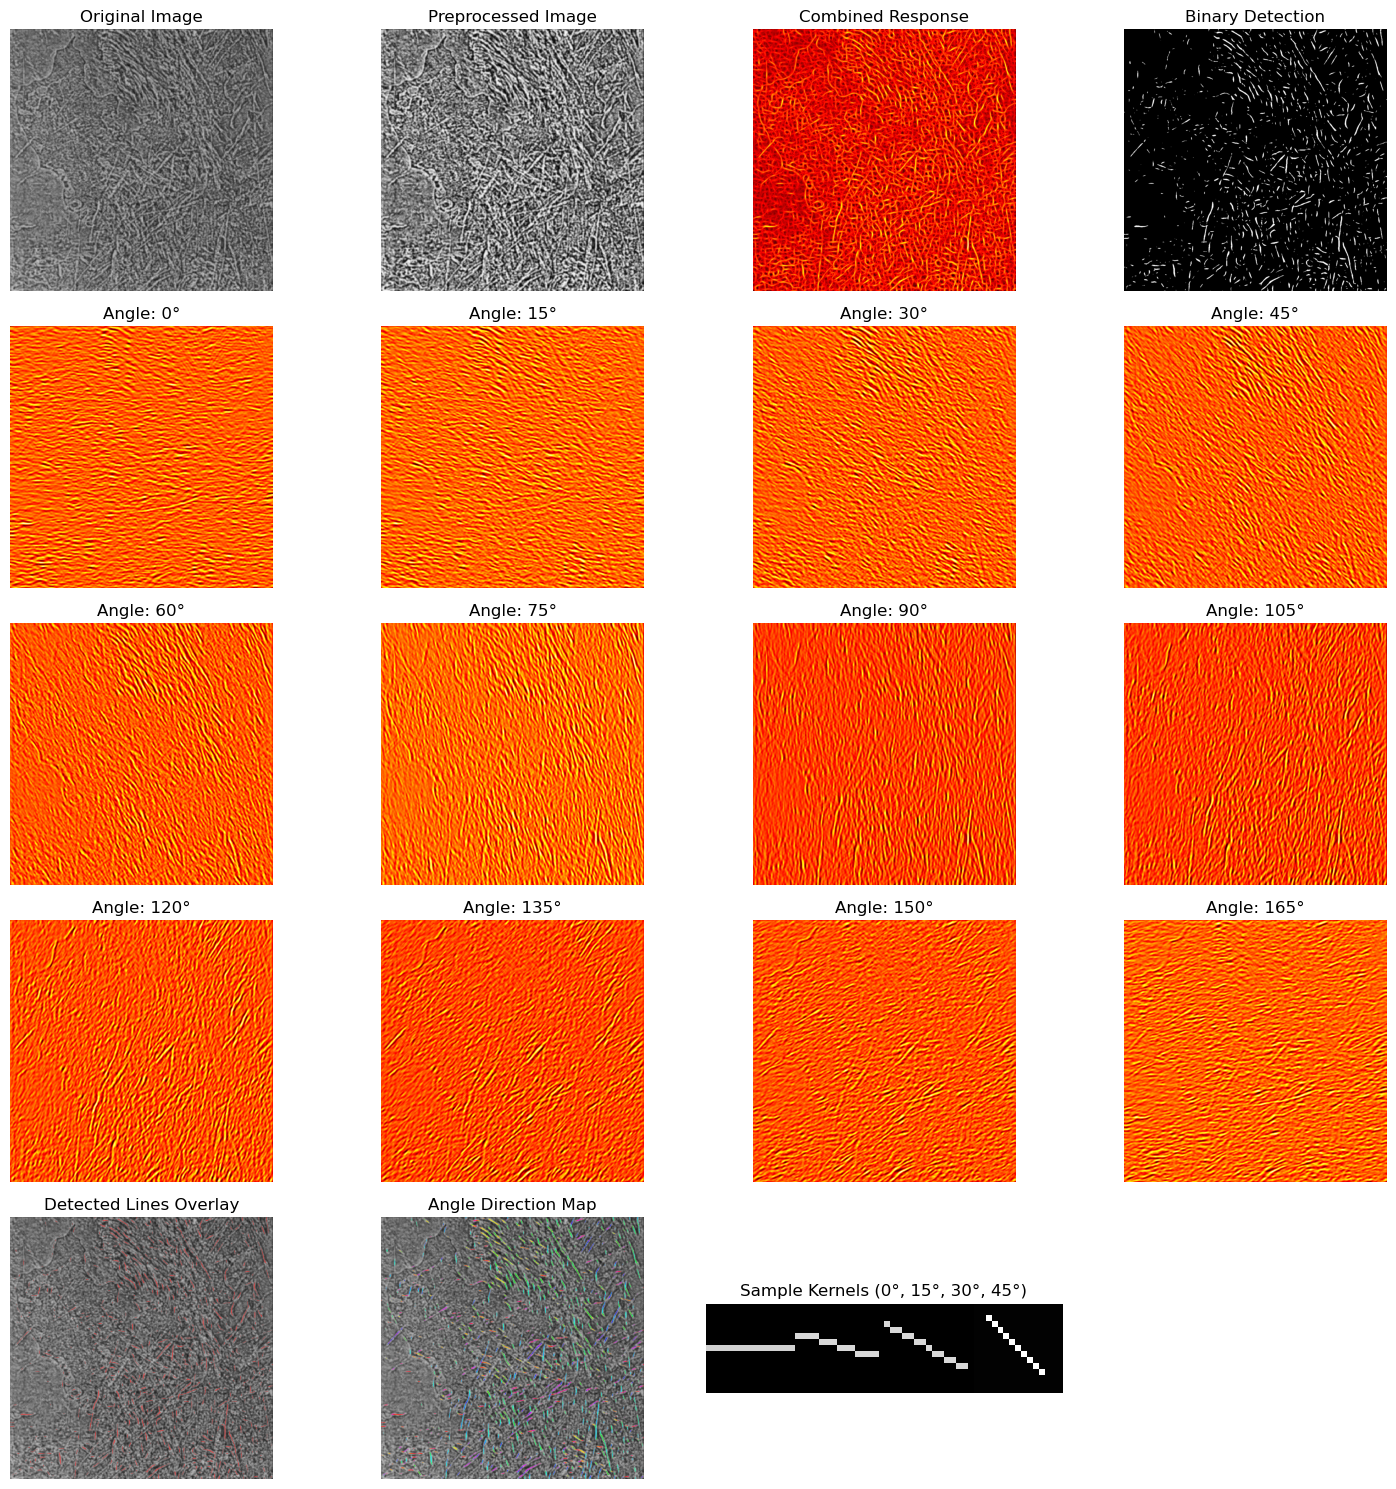

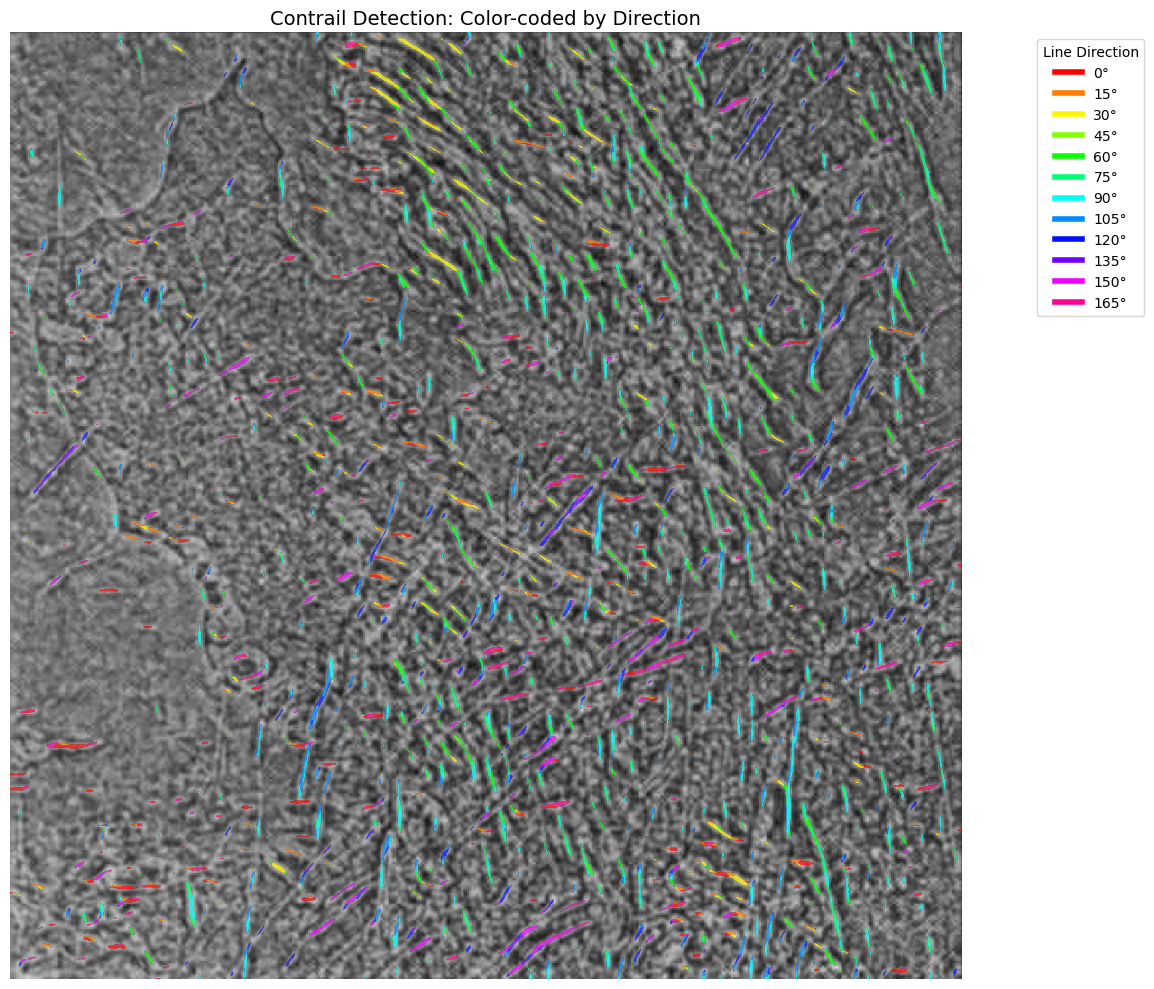

In [32]:
# Visualize results
visualize_results(original_img, preprocessed, max_response, binary_detection, 
                    angle_responses, angle_map, angles, max_angle_idx)